# Figures for WOA 2018 D.O. Research

In [1]:
# import packages
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt
from OMZBDA import getLatSlice, omzbda
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Locations of Latitudinal Slices

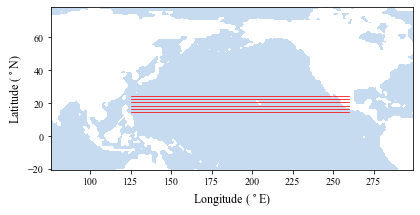

In [2]:
savefig = False
fig_path = './figures/'
fname = 'ex_slices.png'

month = 1

# load dataset
fpath = 'data/'
filename = 'woa18_all_o0'+str(month)+'_01.nc'
ds = Dataset(fpath+filename)

# pull data
lons = ds.variables['lon'][:]    # longitudes (360,)
lats = ds.variables['lat'][:]    # latitudes (180,)
dO = ds.variables['o_an'][0][0][:][:]

# create full grids for each dimension
tempLat = []
tempLon = []

nLons = len(lons)
for lat in lats:
    tempLat.append(np.full(nLons, lat))
    tempLon.append(lons)

# cast to numpy arrays for easier handling
lats = np.array(tempLat)
lons = np.array(tempLon)

# center at Pacific
for i in range(len(lons)):
    for j in range(len(lons[0,:])):
        if lons[i,j] < 0:
            lons[i,j] += 360
            
# reorder data (180 - 360, 0 -179  --> 0 - 360)
temp = 0
for i in range(len(lons)):
    for j in range(180):
        temp = lons[i, j+180]
        lons[i, j+180] = lons[i,j]
        lons[i, j] = temp
        temp = dO[i, j+180]
        dO[i, j+180] = dO[i,j]
        dO[i,j] = temp


# mask to keep only lons of the Pacific
l_plot = 75
r_plot = 300
lon_mask = (lons[0] > l_plot) & (lons[0] < r_plot)
lons_zoom = []
lats_zoom = []
dO_zoom = []
for i in range(len(lons)):
    lons_zoom.append(lons[i][lon_mask])
    lats_zoom.append(lats[i][lon_mask])
    dO_zoom.append(dO[i][lon_mask])
b_plot = -20
t_plot = 80
lat_lo = lats[0,0]
b_i = int((b_plot - lat_lo)/1.)
t_i = int((t_plot - lat_lo)/1.)
lat_mask = (lats)
lons_zoom = lons_zoom[b_i:t_i]
lats_zoom = lats_zoom[b_i:t_i]
dO_zoom = dO_zoom[b_i:t_i]

fig, ax = plt.subplots(figsize=(6.5, 3))  # create figure

# mask land and ocean
land = []
for i in range(len(dO_zoom)):
    land.append(np.ma.getmask(dO_zoom[i]))
land = np.array(land)
land = np.ma.masked_where(land > 0.3, land)
dO_map = plt.contourf(lons_zoom, lats_zoom, land, cmap='Blues')       # create contour plot

# labels
# format ticks
for tick in ax.get_xticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)
for tick in ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)
csfont = {'fontname':'Times New Roman'}
plt.ylabel('Latitude ($^\circ$N)', **csfont, fontsize=12)
plt.xlabel('Longitude ($^\circ$E)', **csfont, fontsize=12)

# draw latitudinal slices
target_lats = np.linspace(15,25,6)  # (15 - 25) by 2 degrees (11 for 1 degree)
left = 125
right = 260
w_plot = r_plot - l_plot
for target_lat in target_lats:
    i_lat = int((target_lat - lat_lo)/1.)
    actual_lat = lats[i_lat,0]
    l = (left-l_plot)/(w_plot)
    r = (right-l_plot)/(w_plot)
    plt.axhline(y=lats[i_lat,0], xmin=l, xmax=r, color='r', linewidth=0.75)
plt.show()

if savefig:
    fig.tight_layout()
    fig.savefig(fig_path+fname, dpi=80)

## Example Latitudinal Slice and OMZ-BDA Run

85.0 1100.0
211.5 259.5


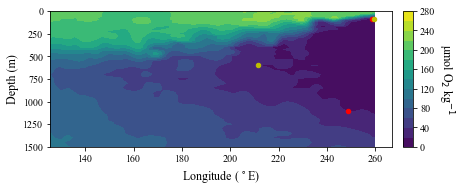

In [3]:
savefig = True
fig_path = './figures/'
fname = 'ex_omzbda.png'

month = 2
filename = 'woa18_all_o0'+str(month)+'_01.nc'

target_lat = 17
i_lat, actual_lat, lons, deps, dO = getLatSlice(filename, target_lat)

top, bottom, left, right, t_pt, b_pt, l_pt, r_pt = omzbda(lons, deps, dO, 20)
print(top, bottom)
print(left, right)

breaks = np.linspace(0, 280, 15)
bticks = np.linspace(0, 280, 8)

fig, ax = plt.subplots(figsize=(6.5, 2.5))     # create figure
dO_map = ax.contourf(lons, deps, dO, breaks)  # create contour plot
plt.gca().invert_yaxis()                   # make depth go down

# format ticks
for tick in ax.get_xticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)
for tick in ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)
    
csfont = {'fontname':'Times New Roman'}
#ax.set_title('Dissolved Oxygen Concentration at ' + str(actual_lat) + '$^\circ$N (Month '+str(month)+')', **csfont, fontsize=13)
ax.set_ylabel('Depth (m)', **csfont, fontsize=12)
ax.set_xlabel('Longitude ($^\circ$E)', **csfont, fontsize=12)
plt.locator_params(axis='y', nbins=7)   # y-axis
plt.locator_params(axis='x', nbins=12)  # x-axis

# colorbar doesn't format with tight_layout, so control cb format manually
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="3%")
cbar = plt.colorbar(dO_map, ticks=bticks, cax = cax)  # add colorbar
cbar.set_label('\u03BCmol O$_2$ kg$^{-1}$', rotation=270, labelpad=20, **csfont, fontsize=12)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)

# plot upper and lower bounds identified by OMZ-BDA
x,y = zip(*[t_pt, b_pt])
ax.scatter(x, y, color='r', s=20)
x,y = zip(*[l_pt, r_pt])
ax.scatter(x, y, color='y', s=20)
plt.show()

if savefig:
    fig.tight_layout()
    fig.savefig(fig_path+fname, dpi=80)

## Animations

In [4]:
# import animation packages
from matplotlib import animation as anm
from IPython.display import HTML

### Through Slices

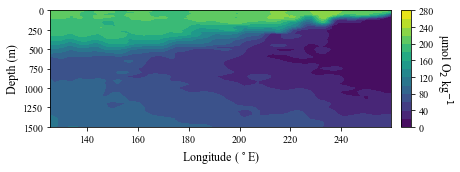

0
0
1
2
3
4
5


In [6]:
savefig = False  # save the figure?
stepSep = 5      # interval of steps in the animation

fpath = './figures/'
fname = 'anm_slices.mp4'

month = 1
fname = 'woa18_all_o0'+str(month)+'_01.nc'

target_lat = 17
i_lat, actual_lat, lons, deps, dO = getLatSlice(fname, target_lat)

breaks = np.linspace(0, 280, 15)
bticks = np.linspace(0, 280, 8)

fig, ax = plt.subplots(figsize=(6.5, 2.5))     # create figure
dO_map = plt.contourf(lons, deps, dO, breaks)  # create contour plot
plt.gca().invert_yaxis()                   # make depth go down

# format ticks
for tick in ax.get_xticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)
for tick in ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)

# format labels
csfont = {'fontname':'Times New Roman'}
plt.ylabel('Depth (m)', **csfont, fontsize=12)
plt.xlabel('Longitude ($^\circ$E)', **csfont, fontsize=12)
plt.locator_params(axis='y', nbins=7)   # y-axis
plt.locator_params(axis='x', nbins=12)  # x-axis

# colorbar doesn't format with tight_layout, so control cb format manually
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="3%")
cbar = plt.colorbar(dO_map, ticks=bticks, cax = cax)  # add colorbar
cbar.set_label('\u03BCmol O$_2$ kg$^{-1}$', rotation=270, labelpad=20, **csfont, fontsize=12)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)

plt.tight_layout()
plt.pause(0.001)

target_lats = np.linspace(15,25,6)  # (15 - 25) by 2 degrees (11 for 1 degree)
def update(i):
    print(i)
    target_lat = target_lats[i]
    i_lat, actual_lat, lons, deps, dO = getLatSlice(fname, target_lat)
    ax.set_title('Dissolved Oxygen Concentration at ' + str(actual_lat) + '$^\circ$N (Month '+str(month)+')', **csfont, fontsize=13)
    
    # update contour plot
    ax.contourf(lons, deps, dO, breaks)  # create contour plot
    
    plt.pause(0.001)

frames = np.arange(0,len(target_lats))

# frames = num of timesteps, interval = time btwn frames in ms
anim = anm.FuncAnimation(fig, update, frames=frames, interval=400)

if savefig:
    # Set up formatting for the movie files
    anim.save(fpath+fname, dpi=120)
    print('saved!')

# uncomment to display animation in this Jupyter Notebook
HTML(anim.to_jshtml())

### One Slice Over Time

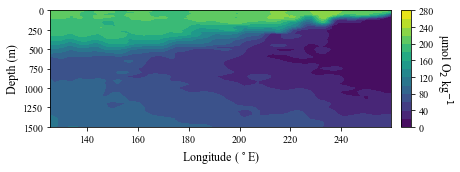

0
0
1
2
3
4
5
6
7
8
9
10
11


In [7]:
savefig = False  # save the figure?
stepSep = 5      # interval of steps in the animation

fpath = './figures/'
fname = 'anm_months.mp4'
target_lat = 17
filenames = [
    'woa18_all_o01_01.nc',
    'woa18_all_o02_01.nc',
    'woa18_all_o03_01.nc',
    'woa18_all_o04_01.nc',
    'woa18_all_o05_01.nc',
    'woa18_all_o06_01.nc',
    'woa18_all_o07_01.nc',
    'woa18_all_o08_01.nc',
    'woa18_all_o09_01.nc',
    'woa18_all_o10_01.nc',
    'woa18_all_o11_01.nc',
    'woa18_all_o12_01.nc'
]

i_lat, actual_lat, lons, deps, dO = getLatSlice(filenames[0], target_lat)

breaks = np.linspace(0, 280, 15)
bticks = np.linspace(0, 280, 8)

fig, ax = plt.subplots(figsize=(6.5, 2.5))     # create figure
dO_map = plt.contourf(lons, deps, dO, breaks)  # create contour plot
plt.gca().invert_yaxis()                   # make depth go down

# format ticks
for tick in ax.get_xticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)
for tick in ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)

# format labels
csfont = {'fontname':'Times New Roman'}
plt.ylabel('Depth (m)', **csfont, fontsize=12)
plt.xlabel('Longitude ($^\circ$E)', **csfont, fontsize=12)
plt.locator_params(axis='y', nbins=7)   # y-axis
plt.locator_params(axis='x', nbins=12)  # x-axis

# colorbar doesn't format with tight_layout, so control cb format manually
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="3%")
cbar = plt.colorbar(dO_map, ticks=bticks, cax = cax)  # add colorbar
cbar.set_label('\u03BCmol O$_2$ kg$^{-1}$', rotation=270, labelpad=20, **csfont, fontsize=12)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    tick.set_fontsize(10)

plt.tight_layout()
plt.pause(0.001)

def update(i):
    print(i)
    i_lat, actual_lat, lons, deps, dO = getLatSlice(filenames[i], target_lat)
    ax.set_title('Dissolved Oxygen Concentration at ' + str(actual_lat) + '$^\circ$N (Month '+str(i+1)+')', **csfont, fontsize=13)
    
    # update contour plot
    ax.contourf(lons, deps, dO, breaks)  # create contour plot
    
    plt.pause(0.001)

frames = np.arange(0,len(filenames))

# frames = num of timesteps, interval = time btwn frames in ms
anim = anm.FuncAnimation(fig, update, frames=frames, interval=400)

if savefig:
    # Set up formatting for the movie files
    anim.save(fpath+fname, dpi=120)
    print('saved!')

# uncomment to display animation in this Jupyter Notebook
HTML(anim.to_jshtml())